In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%tensorflow_version 1.x
!pip install -q keras-vggface
!pip install -q scikit-image
!pip install -q pydot
!pip install -q keras==2.2.5
!pip install h5py==2.10.0  

TensorFlow 1.x selected.


In [ ]:
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.python.lib.io import file_io

%matplotlib inline

import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.vggface import VGGFace
from keras.utils import plot_model
from sklearn.metrics import *
from keras.engine import Model
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D
import skimage
from skimage.transform import rescale, resize

import pydot

Using TensorFlow backend.


In [ ]:
EPOCHS = 50
BS = 128
DROPOUT_RATE = 0.5
FROZEN_LAYER_NUM = 19

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

Resize_pixelsize = 197

In [ ]:
vgg_notop = VGGFace(model='vgg16', include_top=False, input_shape=(Resize_pixelsize, Resize_pixelsize, 3), pooling='avg')
last_layer = vgg_notop.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(1024, activation='relu', name='fc7')(x)

for i in range(FROZEN_LAYER_NUM):
    vgg_notop.layers[i].trainable = False


out = Dense(7, activation='softmax', name='classifier')(x)

model = Model(vgg_notop.input, out)


optim = keras.optimizers.Adam(lr=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = keras.optimizers.SGD(lr=SGD_LEARNING_RATE, momentum=0.9, decay=SGD_DECAY, nesterov=True)
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_acc',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)

mfile = '/content/drive/MyDrive/aml/saved/vgg-cw/my_best_model.epoch{epoch:02d}-loss{val_loss:.3f}.hdf5'
msave = keras.callbacks.ModelCheckpoint(filepath=mfile,verbose=1, save_weights_only=True,period= 10 )

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])





58916864/58909280 [==============================] - 1s 0us/step







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [ ]:
! rm -rf train; mkdir train
! unzip -q '/content/drive/MyDrive/aml/datasets/fer2013/train.zip' -d train

! rm -rf dev; mkdir dev
! unzip -q '/content/drive/MyDrive/aml/datasets/fer2013/test-public.zip' -d dev

! rm -rf test; mkdir test
! unzip -q '/content/drive/MyDrive/aml/datasets/fer2013/test-private.zip' -d test

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_datagen(dataset, aug=False):
    if aug:
        datagen = ImageDataGenerator(
                            rescale=1./255,
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
            dataset,
            target_size=(197, 197),
            color_mode='rgb',
            shuffle = True,
            class_mode='categorical',
            batch_size=BS)

In [ ]:
train_generator  = get_datagen('/content/train', True)
dev_generator    = get_datagen('/content/dev')
test_generator  = get_datagen('/content/test')

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [ ]:
from sklearn.utils import class_weight
file_stream = file_io.FileIO('/content/drive/MyDrive/aml/datasets/fer2013/dev.csv', mode='r')
data = pd.read_csv(file_stream)
data['pixels'] = data['pixels'].apply(lambda x: [int(pixel) for pixel in x.split()])
X, Y = data['pixels'].tolist(), data['emotion'].values
class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(Y),
                                        y = Y     )

In [ ]:
class_weights

array([1.09788926, 9.15561224, 1.03369816, 0.57286512, 0.78516736,
       1.23545611, 0.84466933])

In [ ]:
history = model.fit_generator(
    generator = train_generator,
    validation_data=dev_generator, 
    steps_per_epoch=28709// BS,
    validation_steps=3589 // BS,
    shuffle=True,
    epochs=100,
    callbacks=[rlrop, msave],
    use_multiprocessing=False,
    class_weight = class_weights
) 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
224/224 [==============================] - 356s 2s/step - loss: 1.4460 - acc: 0.4499 - val_loss: 1.1553 - val_acc: 0.5700
Epoch 2/100
224/224 [==============================] - 344s 2s/step - loss: 1.1957 - acc: 0.5548 - val_loss: 1.0979 - val_acc: 0.5978
Epoch 3/100
224/224 [==============================] - 341s 2s/step - loss: 1.1460 - acc: 0.5721 - val_loss: 1.0713 - val_acc: 0.5995
Epoch 4/100
224/224 [==============================] - 338s 2s/step - loss: 1.1195 - acc: 0.5796 - val_loss: 1.0469 - val_acc: 0.6021
Epoch 5/100
224/224 [==============================] - 340s 2s/step - loss: 1.0935 - acc: 0.5901 - val_loss: 1.0221 - val_acc: 0.6203
Epoch 6/100
224/224 [==============================] - 339s 2s/step - loss: 1.0793 - acc: 0.5997 - val_loss: 1.0462 - val_acc: 0.6013
Epoch 7/100
224/224 [==============================] - 337s 2s/step - loss: 1.0610 - acc: 0.6008 - v

In [ ]:
model.load_weights('/content/drive/MyDrive/aml/saved/vgg-cw/my_best_model.epoch30-loss0.924.hdf5')

In [ ]:
history = model.fit_generator(
    generator = train_generator,
    validation_data=dev_generator, 
    steps_per_epoch=28709// BS,
    validation_steps=3589 // BS,
    shuffle=True,
    epochs=70,
    callbacks=[rlrop, msave],
    use_multiprocessing=False,
    class_weight = class_weights
) 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/70
224/224 [==============================] - 354s 2s/step - loss: 0.8651 - acc: 0.6750 - val_loss: 0.9255 - val_acc: 0.6641
Epoch 2/70
224/224 [==============================] - 340s 2s/step - loss: 0.8570 - acc: 0.6788 - val_loss: 0.9168 - val_acc: 0.6637
Epoch 3/70
224/224 [==============================] - 337s 2s/step - loss: 0.8487 - acc: 0.6833 - val_loss: 0.9321 - val_acc: 0.6631
Epoch 4/70
224/224 [==============================] - 336s 1s/step - loss: 0.8404 - acc: 0.6863 - val_loss: 0.9186 - val_acc: 0.6671
Epoch 5/70
224/224 [==============================] - 330s 1s/step - loss: 0.8323 - acc: 0.6899 - val_loss: 0.9290 - val_acc: 0.6524
Epoch 6/70
224/224 [==============================] - 327s 1s/step - loss: 0.8215 - acc: 0.6957 - val_loss: 0.9140 - val_acc: 0.6715
Epoch 7/70
224/224 [==============================] - 325s 1s/step - loss: 0.8159 - acc: 0.6986 - val_loss

In [ ]:
epoch_str = '-EPOCHS_' + str(100)
test_acc = 'test_acc_%.3f' % results_test[1]
model.save('/content/drive/MyDrive/aml/models/' + 'VGG16-CW' + epoch_str + test_acc + '.h5')

In [ ]:
model.load_weights('/content/drive/MyDrive/aml/models/VGG16-CW-EPOCHS_100test_acc_0.701.h5')

In [ ]:
results_dev = model.evaluate_generator(dev_generator, 3589 // BS)
print('dev loss:', results_dev[0],", dev acc:", results_dev[1])

dev loss: 0.9519310700041907 , dev acc: 0.6930803571428571


In [ ]:
results_test = model.evaluate_generator(test_generator, 3599 // BS)
print('test loss:', results_test[0],", test acc:", results_test[1])

test loss: 0.8873257339000702 , test acc: 0.7006138392857143


dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


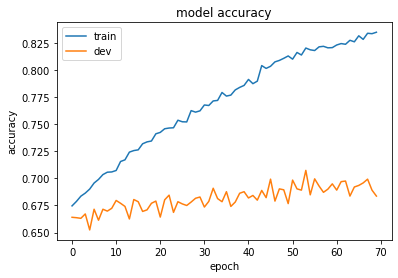

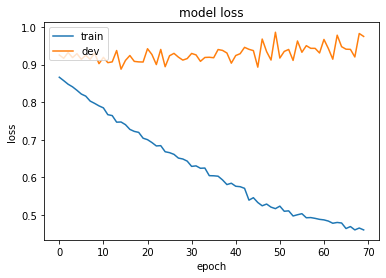

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [ ]:
m='m'

In [ ]:
ffjgbbbbb